In [0]:
%matplotlib inline
import sys
BIN = '../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

#import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
#mpl.rc_file(BIN + 'my_matplotlib_rcparams')

In [0]:
!cp "/content/drive/My Drive/all_jets_train_4D_100_percent.pkl" /content
!cp "/content/drive/My Drive/all_jets_test_4D_100_percent.pkl" /content
train = pd.read_pickle("/content/all_jets_train_4D_100_percent.pkl")
test = pd.read_pickle("/content/all_jets_test_4D_100_percent.pkl")


In [66]:
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
%cd Ranger-Deep-Learning-Optimizer
!pip install -e . 

Cloning into 'Ranger-Deep-Learning-Optimizer'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 79 (delta 0), reused 8 (delta 0), pack-reused 69
Unpacking objects: 100% (79/79), done.
/content/Ranger-Deep-Learning-Optimizer/Ranger-Deep-Learning-Optimizer
Obtaining file:///content/Ranger-Deep-Learning-Optimizer/Ranger-Deep-Learning-Optimizer
  Found existing installation: ranger 0.0.1
    Can't uninstall 'ranger'. No files were found to uninstall.
  Running setup.py develop for ranger


In [67]:
train

,m,pt,phi,eta
132784,3831.839355,22000.609375,1.567018,1.142924
99666,4582.417480,21648.210938,-2.680558,0.213654
26629,16747.765625,169514.281250,-1.948239,1.163296
80473,14789.586914,183085.609375,-1.641102,2.670927
48229,4646.724121,20527.130859,2.922270,-1.158871
...,...,...,...,...
53491,4953.317871,24546.789062,-2.150104,1.652488
106817,13648.668945,101725.289062,2.439408,1.593228
61324,5574.332520,24144.490234,1.226542,1.522092
132003,4341.430664,23436.962891,-2.397882,1.151906


In [0]:
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.FloatTensor(train_x.values), torch.FloatTensor(train_y.values))
valid_ds = TensorDataset(torch.FloatTensor(test_x.values), torch.FloatTensor(test_y.values))

In [0]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [0]:

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=1024)

In [0]:
db = basic_data.DataBunch(train_dl, valid_dl)


In [0]:
class AE(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.en1= nn.Linear(4,200,bias=True)
    self.en2= nn.Linear(200,200,bias=True)
    self.en3= nn.Linear(200,100,bias=True)
    self.en4= nn.Linear(100,100,bias=True)
    self.en5= nn.Linear(100,50,bias=True)
    self.en6 = nn.Linear(50,25,bias=True)
    self.en7 = nn.Linear(25,3,bias=True)
    self.de1 = nn.Linear(3,25,bias=True)
    self.de2 = nn.Linear(25,50,bias=True)
    self.de3 = nn.Linear(50,100,bias=True)
    self.de4 = nn.Linear(100,100,bias=True)
    self.de5 = nn.Linear(100,200,bias=True)
    self.de6= nn.Linear(200,200,bias=True)
    self.de7 = nn.Linear(200,4,bias=True)
    self.tanh=nn.Tanh()
   
  def encoder(self,x):
    x=self.tanh(self.en1(x)).float()
    x=self.tanh(self.en2(x)).float()
    x=self.tanh(self.en3(x)).float()
    x=self.tanh(self.en4(x)).float()
    x=self.tanh(self.en5(x)).float()
    x=self.tanh(self.en6(x)).float()
    return (self.en7(x)).float()
  
  def decoder(self,z):
    z=self.tanh(self.de1(z)).float()
    z=self.tanh(self.de2(z)).float()
    z=self.tanh(self.de3(z)).float()
    z=self.tanh(self.de4(z)).float()
    z=self.tanh(self.de4(z)).float()
    z=self.tanh(self.de5(z)).float()
    z=self.tanh(self.de6(z)).float()
    return (self.de7(z)).float()

  def forward(self,x):
    a=self.encoder(x).float()
    a=self.decoder(a).float()
    return a.float()


In [3]:
model=AE()
model

AE(
  (en1): Linear(in_features=4, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=100, bias=True)
  (en4): Linear(in_features=100, out_features=100, bias=True)
  (en5): Linear(in_features=100, out_features=50, bias=True)
  (en6): Linear(in_features=50, out_features=25, bias=True)
  (en7): Linear(in_features=25, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=25, bias=True)
  (de2): Linear(in_features=25, out_features=50, bias=True)
  (de3): Linear(in_features=50, out_features=100, bias=True)
  (de4): Linear(in_features=100, out_features=100, bias=True)
  (de5): Linear(in_features=100, out_features=200, bias=True)
  (de6): Linear(in_features=200, out_features=200, bias=True)
  (de7): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

In [0]:
!cp "/content/drive/My Drive/AE.pth" "/content"

In [75]:
model.load_state_dict(torch.load("/content/AE.pth"),strict=False)

<All keys matched successfully>

In [0]:
model=model.cpu()

In [0]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss
loss_func = nn.MSELoss().float()

In [0]:
from ranger import Ranger

In [0]:

bn_wd = False  
true_wd = True  
wd = 1e-6
learn = basic_train.Learner(data=db, model=model,opt_func=Ranger , loss_func=loss_func, wd=wd, bn_wd=bn_wd, true_wd=true_wd)

In [80]:

learn.validate()

[0.009698908]

In [21]:
from fastai import train as tr
tr.lr_find(learn)

epoch,train_loss,valid_loss,time


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


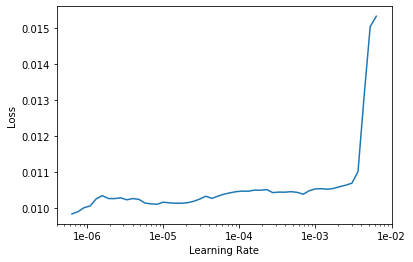

In [22]:
learn.recorder.plot()

In [0]:
lr = 1e-3
learn.fit(10, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.010037,0.011603,00:02
1,0.010396,0.010596,00:02
2,0.010789,0.010555,00:02
3,0.010990,0.011368,00:02
4,0.011300,0.016433,00:02
5,0.011251,0.010830,00:02
6,0.011341,0.016716,00:02
7,0.011417,0.011460,00:02
8,0.010986,0.011478,00:02
9,0.011060,0.012813,00:02


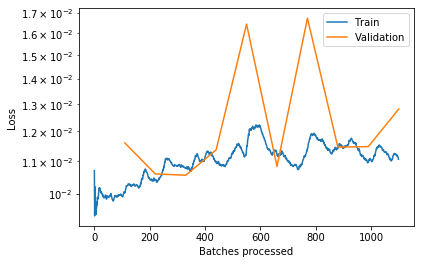

In [0]:
learn.recorder.plot_losses()
plt.yscale('log')

In [23]:
lr = 1e-4
learn.fit(100, lr=lr, wd=wd)

epoch,train_loss,valid_loss,time
0,0.009621,0.010114,00:02
1,0.009514,0.010195,00:02
2,0.009688,0.010262,00:02
3,0.009877,0.010268,00:02
4,0.009677,0.010304,00:02
5,0.009624,0.010079,00:02
6,0.009651,0.010236,00:02
7,0.009508,0.010365,00:02
8,0.009827,0.010223,00:02
9,0.009573,0.010134,00:02


KeyboardInterrupt: ignored

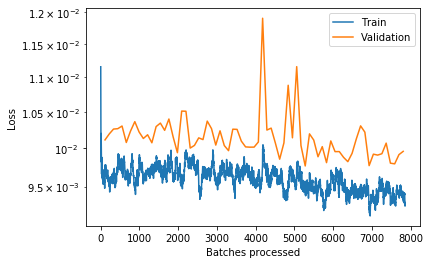

In [25]:
learn.recorder.plot_losses()
plt.yscale('log')

In [102]:
lr = 1e-8
learn.fit(30, lr=lr)

epoch,train_loss,valid_loss,time
0,0.009144,0.009699,00:03
1,0.009108,0.009699,00:03
2,0.009160,0.009699,00:03
3,0.009130,0.009699,00:03
4,0.009232,0.009699,00:03
5,0.009045,0.009699,00:03
6,0.008916,0.009699,00:03
7,0.009175,0.009699,00:03
8,0.008961,0.009699,00:03
9,0.009150,0.009699,00:03


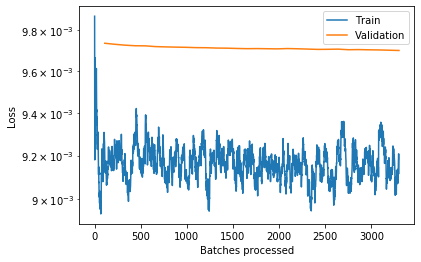

In [27]:
learn.recorder.plot_losses()
plt.yscale('log')

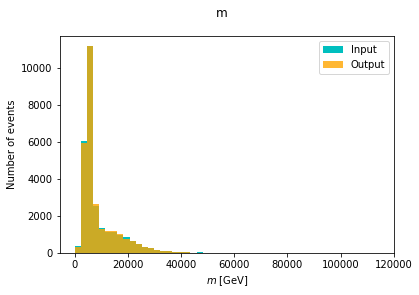

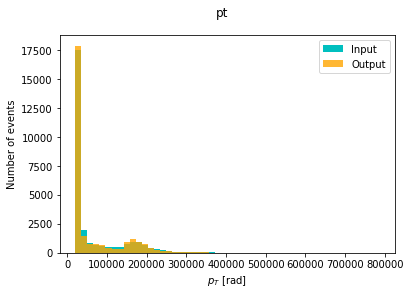

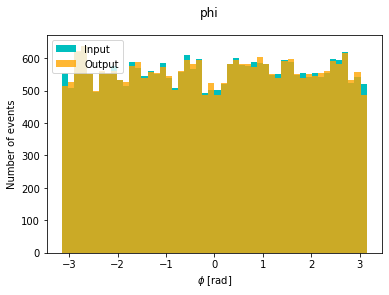

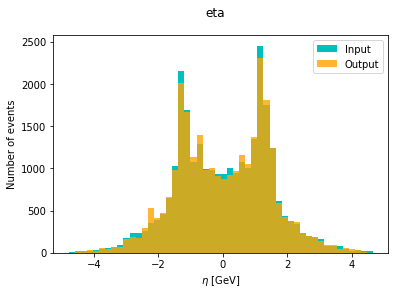

In [109]:
plt.clf()
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:].values).float()
pred = model(data).detach().numpy()
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

alph = 0.8
n_bins = 50
for kk in np.arange(4):
    plt.figure(kk + 4)
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=.8, bins=bin_edges)
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)


In [0]:
torch.save(model.state_dict(),"/content/drive/My Drive/AE.pth")

In [0]:
data = torch.tensor(test_x[0:].values).float()
pred = model(data).detach().numpy()

In [50]:
pred

array([[-0.531053, -0.572877,  1.084166, -0.078668],
       [-0.480317, -0.563204,  0.573814,  0.471673],
       [-0.4898  , -0.568987, -0.62311 ,  0.533864],
       [ 0.676679,  1.880558,  0.174711, -1.451397],
       ...,
       [-0.408771, -0.553371, -0.446851,  0.684093],
       [-0.561992, -0.520445, -1.209194, -1.620633],
       [-0.180794, -0.409691, -1.485495, -0.618433],
       [ 0.024449, -0.141761, -1.127304,  0.3942  ]], dtype=float32)

In [0]:
pred=pd.DataFrame(pred)

In [0]:
test_x.reset_index(inplace=True)
train_x.reset_index(inplace=True)

In [90]:
test_x.head()

,index,m,pt,phi,eta
0,85972,-0.533282,-0.581905,1.087244,-0.071133
1,38742,-0.472437,-0.609328,0.573286,0.476957
2,128711,-0.498829,-0.570312,-0.622658,0.542203
3,28751,0.697978,1.984290,0.178861,-1.805121
4,131358,-0.754120,-0.566174,0.218307,0.964189


In [91]:
pred.head()

,0,1,2,3
0,-0.694137,-0.612456,0.866374,0.761805
1,-0.589573,-0.594769,-1.491089,0.117831
2,1.059941,1.234108,-1.086227,0.537455
3,0.904177,1.419504,-0.911811,1.686114
4,-0.585355,-0.593466,1.618036,-0.824856


In [0]:
test_x.drop(columns='index',inplace=True)
train_x.drop(columns='index',inplace=True)


In [0]:
m=test_x.loc[:,'m']-pred.loc[:,0]
m=m/test_x.loc[:,'m']
pt=test_x.loc[:,'pt']-pred.loc[:,1]
pt=pt/test_x.loc[:,'pt']
phi=test_x.loc[:,'phi']-pred.loc[:,2]
phi=phi/test_x.loc[:,'phi']
eta=test_x.loc[:,'eta']-pred.loc[:,3]
eta=eta/test_x.loc[:,'eta']

(array([36., 31., 44., 32., ..., 62., 40., 50., 47.]),
 array([-1.  , -0.98, -0.96, -0.94, ...,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 100 Patch objects>)

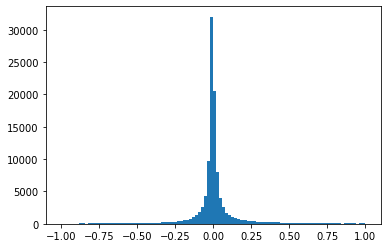

In [97]:
mpl.pyplot.hist(np.array(m),bins=100,range=(-1,1))


(array([2., 5., 3., 5., ..., 6., 4., 3., 5.]),
 array([-1.  , -0.98, -0.96, -0.94, ...,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 100 Patch objects>)

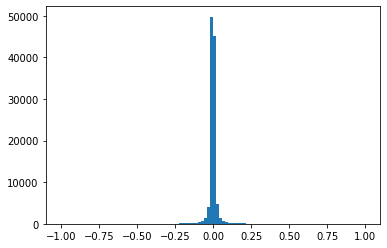

In [98]:
mpl.pyplot.hist(np.array(phi),bins=100,range=(-1,1))


(array([30., 36., 37., 36., ..., 18., 19., 23., 21.]),
 array([-1.  , -0.98, -0.96, -0.94, ...,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 100 Patch objects>)

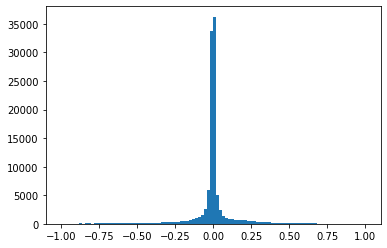

In [99]:
mpl.pyplot.hist(np.array(eta),bins=100,range=(-1,1))


(array([49., 49., 42., 53., ..., 46., 40., 34., 31.]),
 array([-1.  , -0.98, -0.96, -0.94, ...,  0.94,  0.96,  0.98,  1.  ]),
 <a list of 100 Patch objects>)

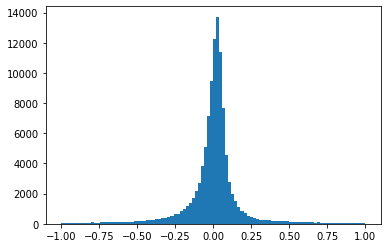

In [100]:
mpl.pyplot.hist(np.array(pt),bins=100,range=(-1,1))